# Democracy Indicators vs. Incarcerations Rates:
---
This notebook models the relationship between democracy indicators and incarcerations rates it used data from four different sources:

        *Incarceration rates from the UN

        *Two Indicators from the Freedom House Project 

        *25+ Indicators from the Quality of Government Institute

        *Democracy Index from the Economist Intelligence Unit

## IMPORTS

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

## Preprosessing the UN Incarceration Dataset

In [57]:

incarceration_rates = pd.read_csv('../../Datasets/Processed_Data/UN_Incarceration_Rates_Modeling.csv')

In [58]:
# Narrowing down our target years
incarceration_rates = incarceration_rates.loc[incarceration_rates['Year'].isin([2010,2011,2012,2013,2014,2015,
                                            2016,2017,2018,2019,2020,2021])]

In [59]:
 # Narrowing down the dataset to only the Metrics needed for modeling
incarceration_rates = incarceration_rates[incarceration_rates['Unit of measurement'] == 'Rate per 100,000 population']
incarceration_rates = incarceration_rates[incarceration_rates['Age'] == 'Total']
incarceration_rates = incarceration_rates[incarceration_rates['Sex'] == 'Total']
incarceration_rates = incarceration_rates[incarceration_rates['Indicator'] == 'Persons held']
incarceration_rates = incarceration_rates[incarceration_rates['Dimension'] == 'Total']
incarceration_rates = incarceration_rates[incarceration_rates['Unit of measurement'] == 'Rate per 100,000 population']

In [60]:
incarceration_rates.head()

,Country,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE
48166,Afghanistan,Persons held,Total,Total,Total,Total,2010,"Rate per 100,000 population",64.857087
48167,Anguilla,Persons held,Total,Total,Total,Total,2010,"Rate per 100,000 population",440.344684
48168,Albania,Persons held,Total,Total,Total,Total,2010,"Rate per 100,000 population",159.847628
48169,Andorra,Persons held,Total,Total,Total,Total,2010,"Rate per 100,000 population",61.521683
48170,Argentina,Persons held,Total,Total,Total,Total,2010,"Rate per 100,000 population",144.104192


In [61]:
# Dropping the last of unnecessary columns
incarceration_rates.drop(columns=['Age', 'Sex', 'Dimension', 'Indicator','Category','Unit of measurement'],inplace=True)

# Renaming the VALUE Column
incarceration_rates.rename(columns= {'VALUE':'Incarceration_Rate_Per_100_000'},inplace=True)

In [62]:
incarceration_rate_Country_list = incarceration_rates['Country'].unique().tolist()

len(incarceration_rate_Country_list) # Checking the total number of countries available for this dataset

221

## Preprosessing the Freedom House Project Indicator dataset

In [63]:
civil_political_rights = pd.read_csv('../../Datasets/Processed_Data/CvilLiberties_PoliticalRights_Modeling.csv')
civil_political_rights.head()

,Country,Year,Political_Rights,Civil_Liberties
0,Abkhazia,2022,17,23
1,Afghanistan,2022,1,9
2,Albania,2022,28,39
3,Algeria,2022,10,22
4,Andorra,2022,38,55


In [64]:
# Narrowing down the Years
civil_political_rights = civil_political_rights.loc[civil_political_rights['Year'].isin([2010,2011,2012,2013,2014,2015,
                                                                                         2016,2017,2018,2019,2020,2021])]

# Checking missing values and data types
civil_political_rights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2510 entries, 210 to 2719
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           2510 non-null   object
 1   Year              2510 non-null   int64 
 2   Political_Rights  2510 non-null   int64 
 3   Civil_Liberties   2510 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 98.0+ KB


In [65]:
freedom_house_Country_list = civil_political_rights['Country'].unique().tolist()
len(freedom_house_Country_list) # Checking on the unique Countries for this dataset

213

## Preprocessing the Quality of Government Institute dataset

In [66]:
qgi_indicators = pd.read_csv('../../Datasets/Processed_Data/Quality_Of_Govt_Inst_OECD_Narrow_Indicator_List.csv')
qgi_indicators.head()

,Country,Year,bicc_gmi,cspf_sfi,gd_ptsa,gggi_ggi,gpi_conf,gpi_gpi,gpi_mil,gpi_ss,...,wdi_homicidesf,wdi_homicidesm,wdi_inflation,wdi_lfpedubf,wdi_nersf,wdi_nersm,wdi_unempilo,wdi_unempmilo,wdi_unempmne,wdi_unempne
0,Australia,2010,143.994881,2.0,1.0,0.7271,1.168,1.439,1.649,1.541,...,0.845536,1.239729,2.918340,56.480000,NaN,NaN,5.21,5.070,5.07,5.21
1,Australia,2011,150.659480,2.0,1.0,0.7291,1.220,1.497,1.713,1.602,...,0.798455,1.402421,3.303850,56.889999,NaN,NaN,5.08,4.894,4.89,5.08
2,Australia,2012,152.628837,2.0,1.0,0.7294,1.188,1.451,1.703,1.526,...,0.724037,1.398546,1.762780,57.880001,NaN,NaN,5.22,5.134,5.14,5.22
3,Australia,2013,149.749281,2.0,NaN,0.7390,1.100,1.386,1.658,1.471,...,0.806875,1.301160,2.449889,44.430000,NaN,NaN,5.66,5.706,5.71,5.66
4,Australia,2014,152.174037,2.0,2.0,0.7409,1.046,1.359,1.664,1.449,...,0.794519,1.266429,2.487923,44.509998,NaN,NaN,6.08,6.002,6.00,6.08


In [67]:
# Narrowing down the Years
qgi_indicators = qgi_indicators.loc[qgi_indicators['Year'].isin([2010,2011,2012,2013,2014,2015,
                                                                 2016,2017,2018,2019,2020,2021])]

# Checking missing values and data types
qgi_indicators.info() # We have a lot of missing values, I will use KNNImputer to fill them in later

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 492
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         456 non-null    object 
 1   Year            456 non-null    int64  
 2   bicc_gmi        444 non-null    float64
 3   cspf_sfi        333 non-null    float64
 4   gd_ptsa         347 non-null    float64
 5   gggi_ggi        455 non-null    float64
 6   gpi_conf        444 non-null    float64
 7   gpi_gpi         444 non-null    float64
 8   gpi_mil         444 non-null    float64
 9   gpi_ss          444 non-null    float64
 10  hum_satdem      216 non-null    float64
 11  hum_sti         145 non-null    float64
 12  nelda_vcdbe     142 non-null    float64
 13  spi_bn          456 non-null    float64
 14  spi_fob         456 non-null    float64
 15  spi_opp         456 non-null    float64
 16  spi_ospi        456 non-null    float64
 17  undp_hdi        456 non-null    float64


In [68]:
qgi_indicators_Country_list = qgi_indicators['Country'].unique().tolist()
len(qgi_indicators) # Checking on the unique Countries for this dataset

456

## Reading in the Democracy Index

In [69]:
democracy_index = pd.read_csv('../../Datasets/Original_Data/Economist_Intelligence_Unit_Democracy_Index_2022_0-10.csv')

In [70]:
democracy_index.rename(columns= {'Entity':'Country', 'democracy_eiu':'democracy_index'},inplace=True)
democracy_index = democracy_index.loc[democracy_index['Year'].isin([2010,2011,2012,2013,2014,2015,
                                            2016,2017,2018,2019,2020,2021])]


In [71]:
democracy_index.head()

,Country,Year,democracy_index
2,Afghanistan,2010,2.48
3,Afghanistan,2011,2.48
4,Afghanistan,2012,2.48
5,Afghanistan,2013,2.48
6,Afghanistan,2014,2.77


In [72]:
democracy_index_Country_list = democracy_index['Country'].unique().tolist()
len(democracy_index_Country_list)

174

## Filtering down all datasets to only the countries they have in common

In [73]:
country_list_1 = [country for country in freedom_house_Country_list if country in democracy_index_Country_list]
len(country_list_1)

160

In [74]:
country_list_2 = [country for country in incarceration_rate_Country_list if country in country_list_1]
len(country_list_2)

145

In [75]:
country_list_3 = [country for country in qgi_indicators_Country_list if country in country_list_2]
len(country_list_3)

35

In [76]:

# 'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA'

In [77]:
incarceration_rates = incarceration_rates.loc[incarceration_rates['Country'].isin(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA'])]

In [78]:
civil_political_rights = civil_political_rights.loc[civil_political_rights['Country'].isin(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA'])]

In [79]:
qgi_indicators = qgi_indicators.loc[qgi_indicators['Country'].isin(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA'])]

In [80]:
democracy_index = democracy_index.loc[democracy_index['Country'].isin(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'USA'])]

### Merging the Datasets for modeling

In [81]:
democracy_index.shape, incarceration_rates.shape, civil_political_rights.shape, qgi_indicators.shape

((420, 3), (434, 3), (420, 4), (420, 31))

In [82]:
modeling_data =  democracy_index.merge(incarceration_rates, on=['Country','Year'])

In [83]:
modeling_data = modeling_data.merge(civil_political_rights, on=['Country','Year'])

In [84]:
modeling_data = modeling_data.merge(qgi_indicators, on=['Country','Year'] )

In [85]:
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         434 non-null    object 
 1   Year                            434 non-null    int64  
 2   democracy_index                 434 non-null    float64
 3   Incarceration_Rate_Per_100_000  434 non-null    float64
 4   Political_Rights                434 non-null    int64  
 5   Civil_Liberties                 434 non-null    int64  
 6   bicc_gmi                        422 non-null    float64
 7   cspf_sfi                        321 non-null    float64
 8   gd_ptsa                         328 non-null    float64
 9   gggi_ggi                        434 non-null    float64
 10  gpi_conf                        423 non-null    float64
 11  gpi_gpi                         423 non-null    float64
 12  gpi_mil                         423 

In [86]:
modeling_data.to_csv('../../Datasets/Processed_Data/UN_EIU_FH_QOGI_Combined.csv')

### Creating a Correlation Matrix for both Democracy Index and Incarceration Rate

In [87]:
modeling_data.head()

,Country,Year,democracy_index,Incarceration_Rate_Per_100_000,Political_Rights,Civil_Liberties,bicc_gmi,cspf_sfi,gd_ptsa,gggi_ggi,...,wdi_homicidesf,wdi_homicidesm,wdi_inflation,wdi_lfpedubf,wdi_nersf,wdi_nersm,wdi_unempilo,wdi_unempmilo,wdi_unempmne,wdi_unempne
0,Australia,2010,9.22,138.470261,39,57,143.994881,2.0,1.0,0.7271,...,0.845536,1.239729,2.918340,56.480000,NaN,NaN,5.21,5.070,5.07,5.21
1,Australia,2011,9.22,130.187215,39,57,150.659480,2.0,1.0,0.7291,...,0.798455,1.402421,3.303850,56.889999,NaN,NaN,5.08,4.894,4.89,5.08
2,Australia,2012,9.22,129.265046,39,57,152.628837,2.0,1.0,0.7294,...,0.724037,1.398546,1.762780,57.880001,NaN,NaN,5.22,5.134,5.14,5.22
3,Australia,2013,9.13,133.148542,39,58,149.749281,2.0,NaN,0.7390,...,0.806875,1.301160,2.449889,44.430000,NaN,NaN,5.66,5.706,5.71,5.66
4,Australia,2014,9.01,148.042703,39,58,152.174037,2.0,2.0,0.7409,...,0.794519,1.266429,2.487923,44.509998,NaN,NaN,6.08,6.002,6.00,6.08


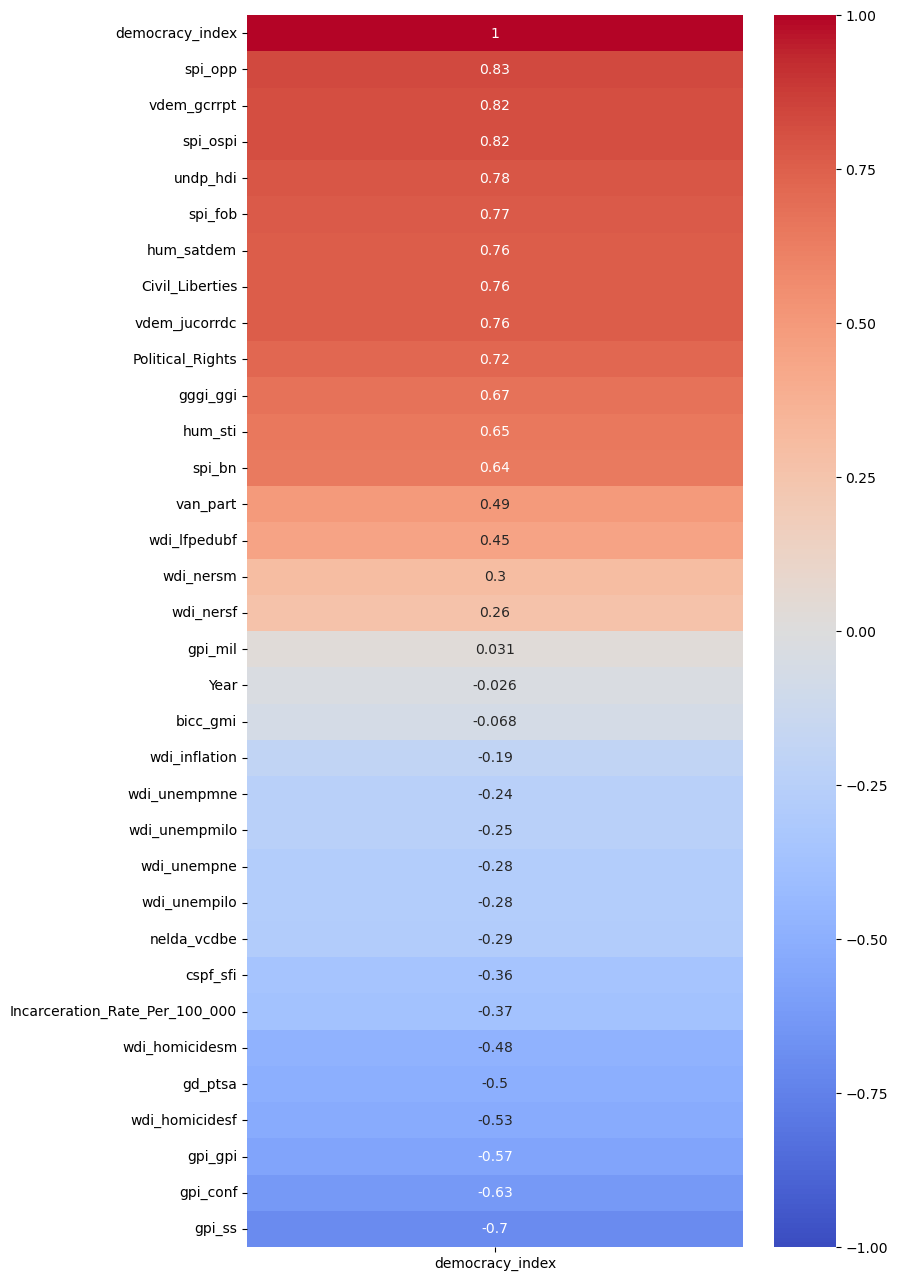

In [88]:
# Heatmap for Democracy Index:
democracy_index_corr = pd.DataFrame(modeling_data.corr(numeric_only = True)['democracy_index'].sort_values(ascending = False))
plt.figure(figsize = (8,16))

sns.heatmap(data = democracy_index_corr, 
            annot = True, 
            vmin = -1, 
            vmax = 1,
            cmap = 'coolwarm');



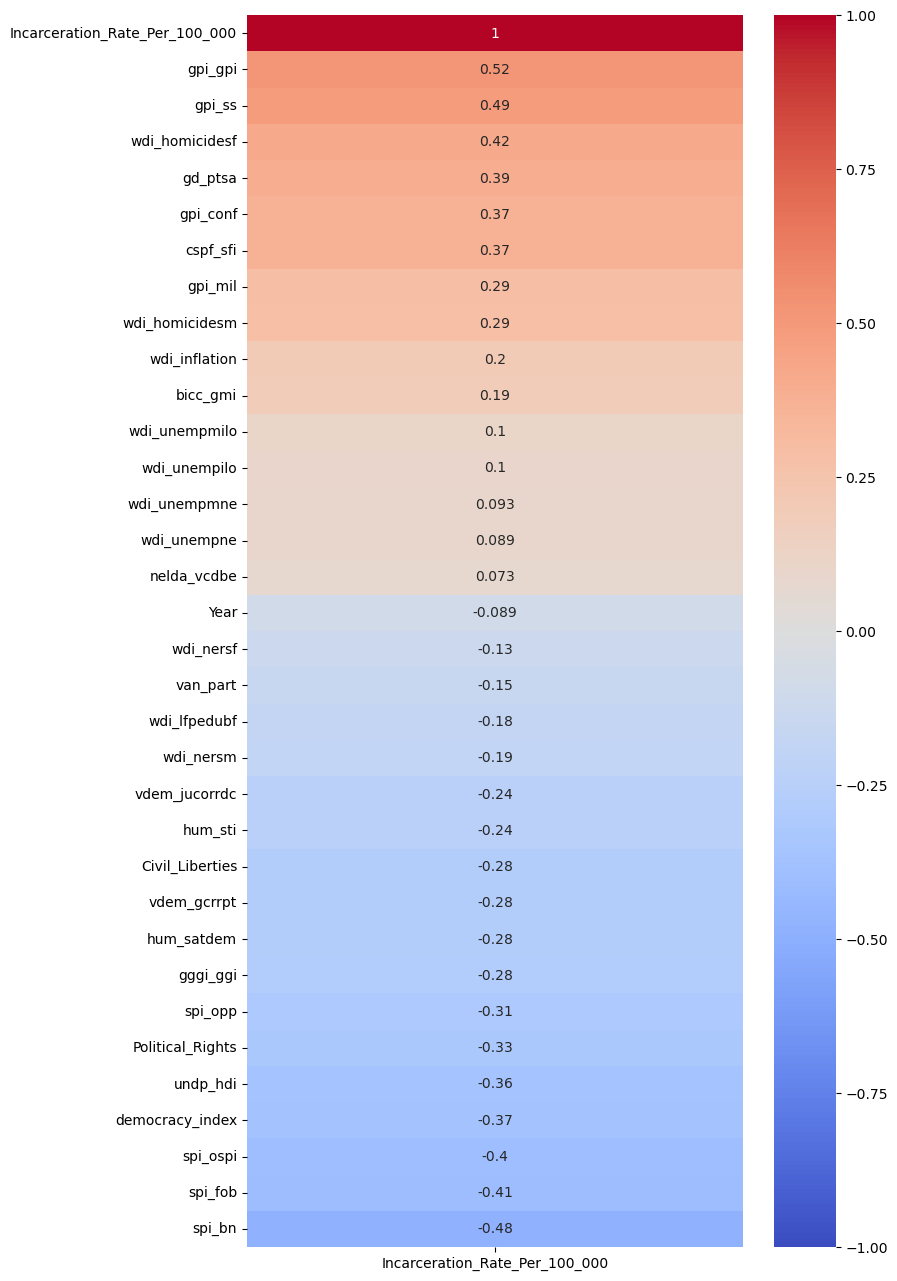

In [89]:
# Heatmap for Democracy Index:
incarceration_rate_corr = pd.DataFrame(modeling_data.corr(numeric_only = True)['Incarceration_Rate_Per_100_000'].sort_values(ascending = False))
plt.figure(figsize = (8,16))

sns.heatmap(data = incarceration_rate_corr, 
            annot = True, 
            vmin = -1, 
            vmax = 1,
            cmap = 'coolwarm');

### From these heatmaps, I have identified the following indicators as most significant with regards to Democracy Index and Incarceration Rates, and have also chosen them because of clarity of the original documentation: 

### Correlations with Incarceration Rate:

[Institute for Economics & Peace](https://www.visionofhumanity.org/resources/)
         
Global Peace Index(gpi_gpi) (1-5) 0.52 correlation

Safety and Security (gpi_ss) (1-5) 0.42 correlation

[The World Bank Group Collection of Development Indicators](https://databank.worldbank.org/source/world-development-indicators)

International Female Homicide (rate per 100,000)(wdi_homicidesf), 0.42 correlation 

[The Freedom House Report](https://freedomhouse.org/sites/default/files/2023-03/FIW_World_2023_DigtalPDF.pdf)
         
Civil Liberties Aggregate (0-40) 0.52 correlation

Political Rights Aggregate (0-60) 0.42 correlation

[Amnesty International](https://www.politicalterrorscale.org/)
         
Political Terror Scale (gd_ptsa)(1-5) 0.39 correlation

[Social Progress Imperative](https://www.socialprogress.org/static/8a62f3f612c8d40b09b3103a70bdacab/2022%20Social%20Progress%20Index%20Executive%20Summary_4.pdf)
         
Basic Human Needs (spi_bn)(0-100) 0.039 correlation
         
Foundations of Wellbeing (spi_fob) (0-100) -0.41 correlation


### Correlations with Democracy Index:

[Social Progress Imperative](https://www.socialprogress.org/static/8a62f3f612c8d40b09b3103a70bdacab/2022%20Social%20Progress%20Index%20Executive%20Summary_4.pdf)

Opportunity Index (spi_opp)(0-100) 0.83 correlation

Foundations of Wellbeing (spi_fob)(0-100) 0.77 correlation 

[Varieties of Democracy (V-Dem) Project](https://v-dem.net/en/data/)
         
Legislature Corrupt Activities (vdem_gcrrpt) (0-4) 0.82 correlation

Judicial Corruption Decisions (vdem_jucorrdc)(0-4) 0.76 correlation

[United Nations Development Program](https://hdr.undp.org/system/files/documents/global-report-document/hdr2021-22pdf_1.pdf)

Human Development Index (undp_hdi) (0-1) 0.78 correlation 

[World Economic Forum](https://www.weforum.org/reports/global-gender-gap-report-2022/)

Overall Global Gender Gap Index (gggi_ggi) (0-100) 0.67 correlation

[Institute for Economics & Peace](https://www.visionofhumanity.org/resources/)

Ongoing Conflict (gpi_conf) (1-5) -0.57 correlation

Safety and Security (gpi_ss) (1-5) -0.70 correlation

In [100]:
pairplot_1_inidicators = modeling_data[['vdem_gcrrpt', 'vdem_jucorrdc','spi_fob', 'spi_opp', 'spi_bn',
                                      'democracy_index','Incarceration_Rate_Per_100_000']]

pairplot_2_indicators = modeling_data[['undp_hdi','Civil_Liberties', 'Political_Rights', 'gd_ptsa',
                                      'democracy_index','Incarceration_Rate_Per_100_000']]

pairplot_3_inidicators = modeling_data[['gpi_gpi', 'gpi_ss','gpi_conf', 'gggi_ggi', 
                           'democracy_index','Incarceration_Rate_Per_100_000']]

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


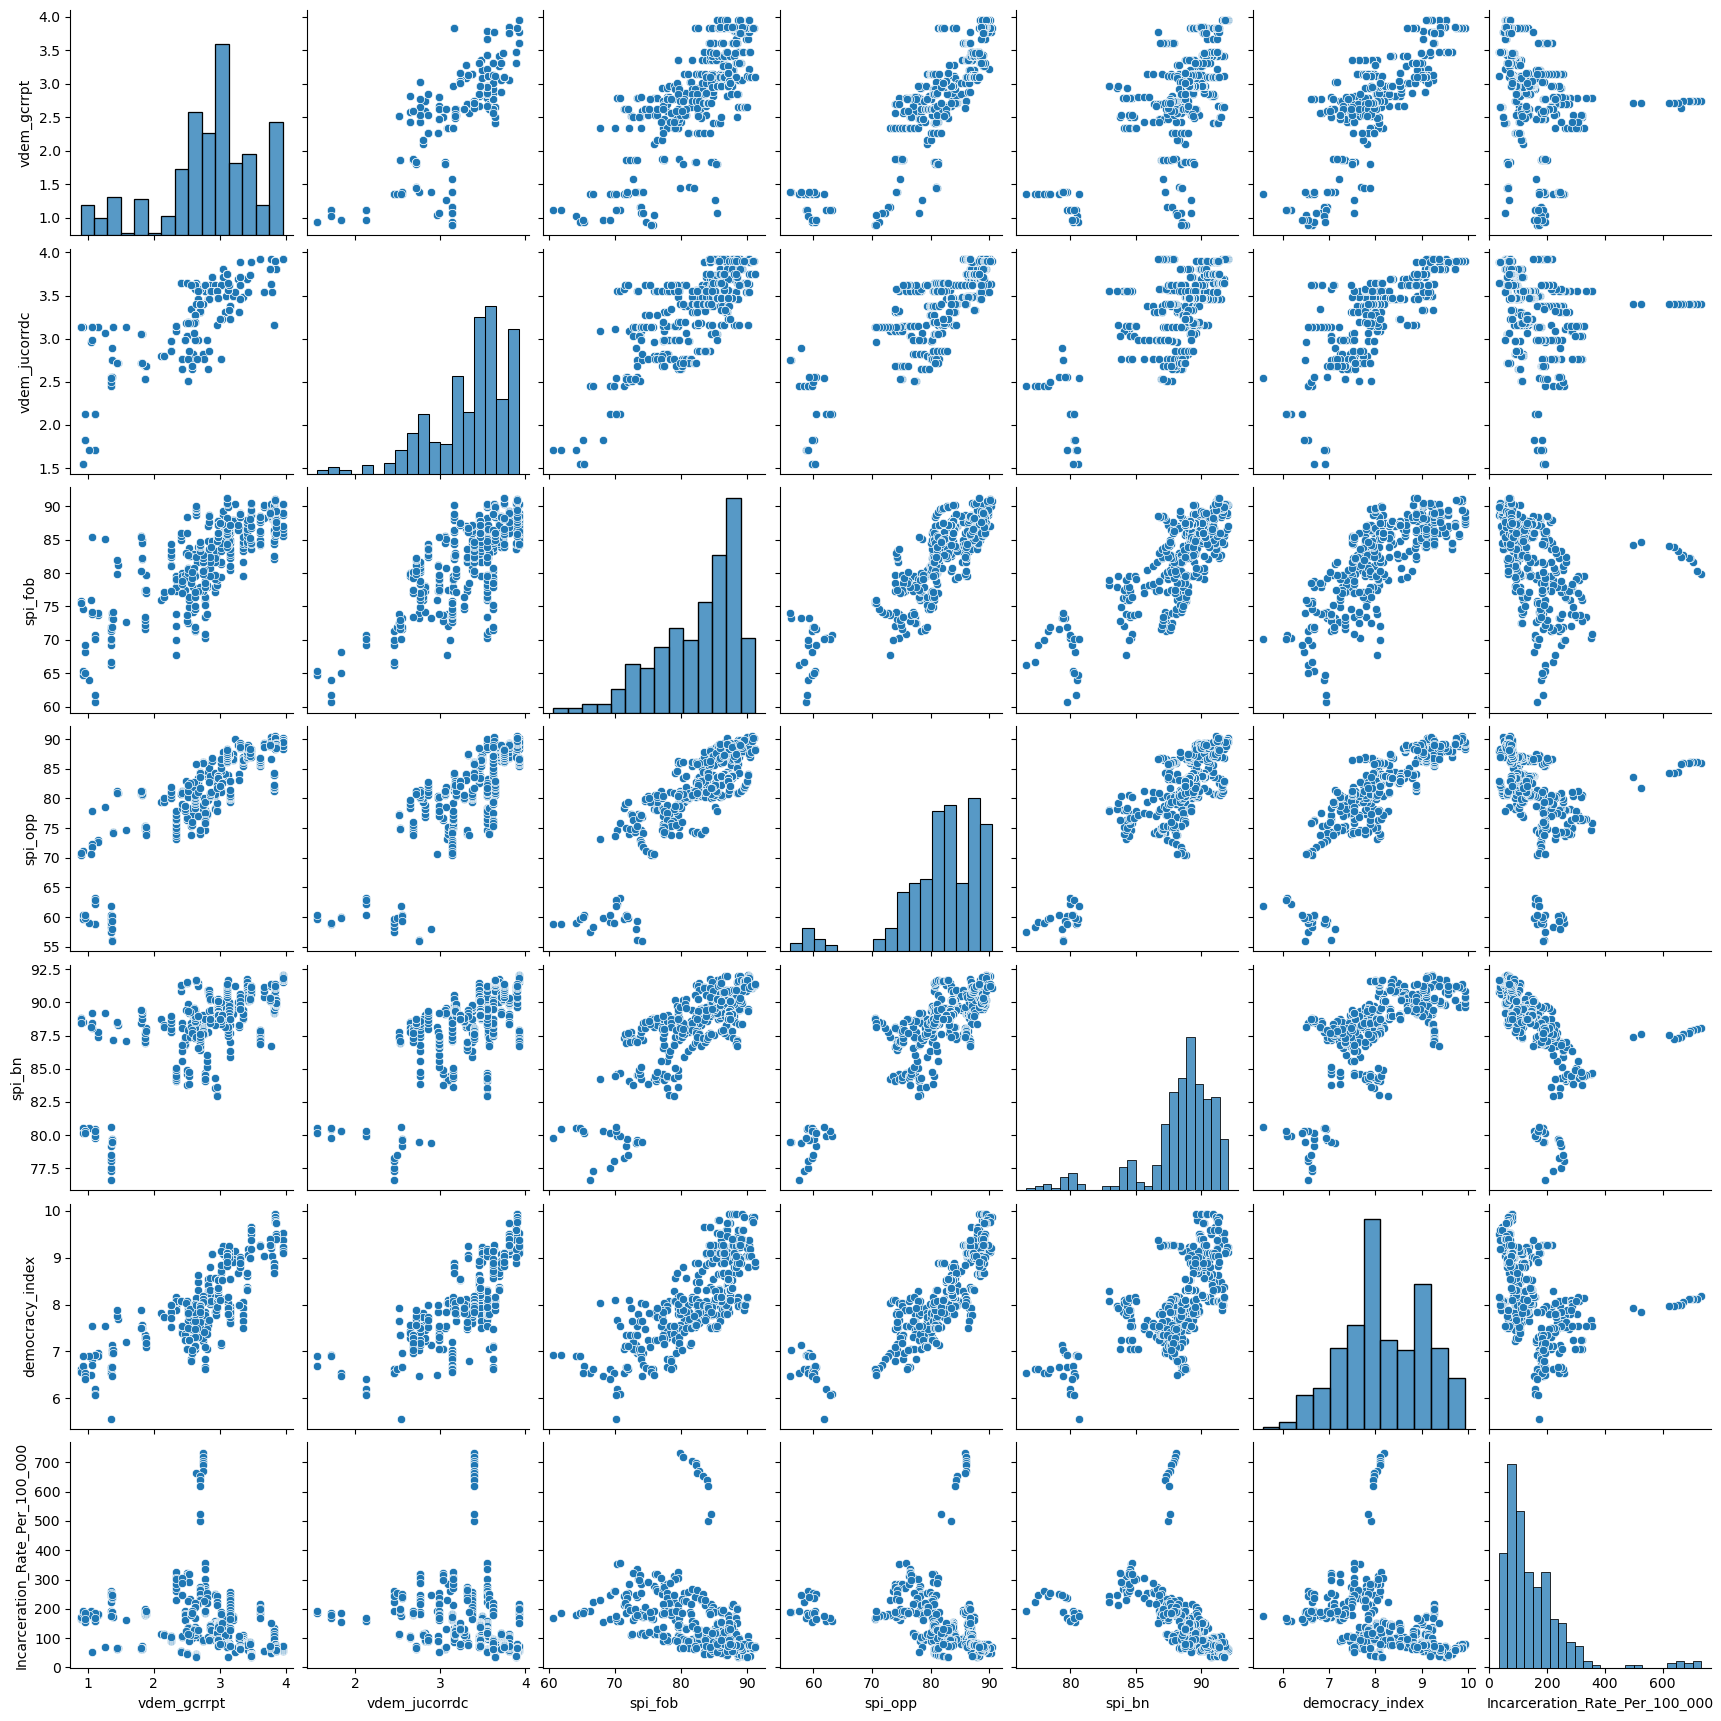

In [101]:
sns.pairplot(pairplot_1_inidicators)

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


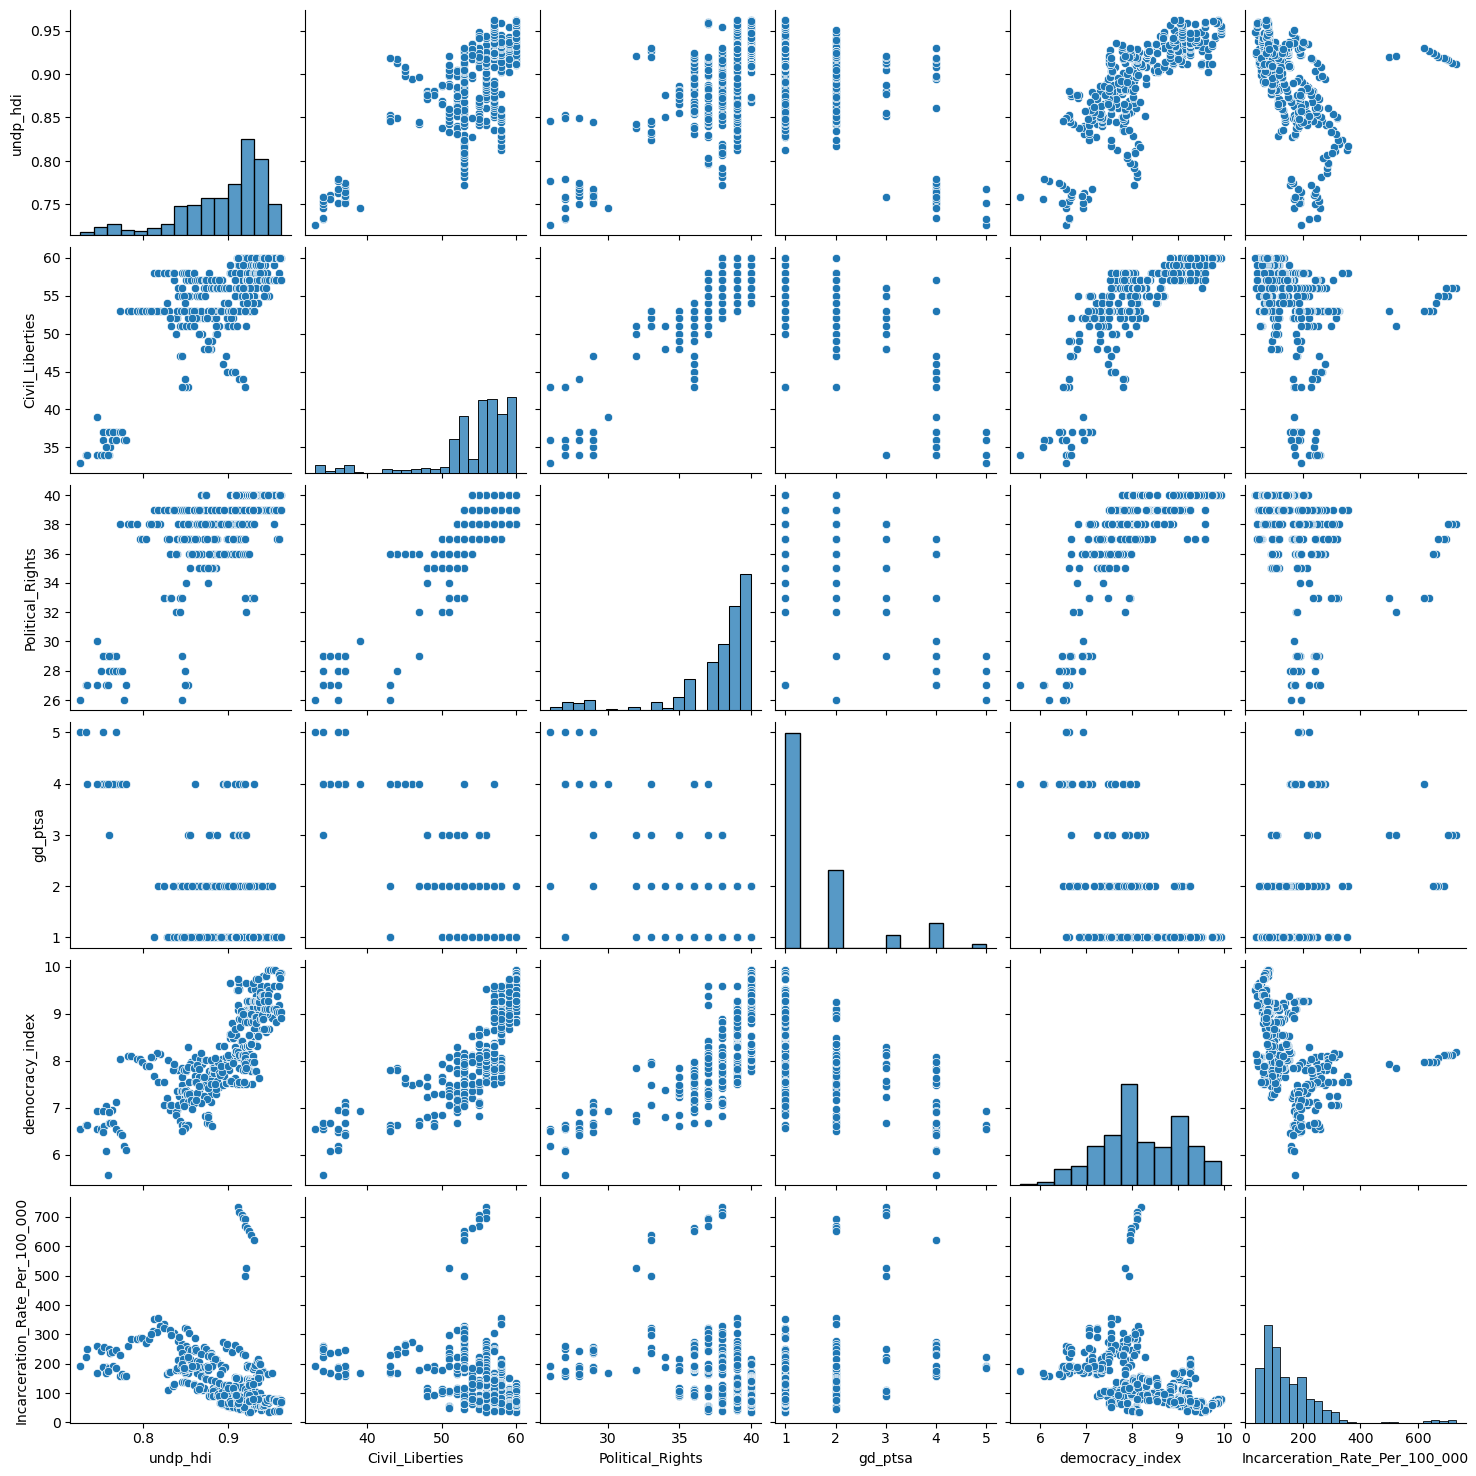

In [96]:
sns.pairplot(pairplot_2_indicators)

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


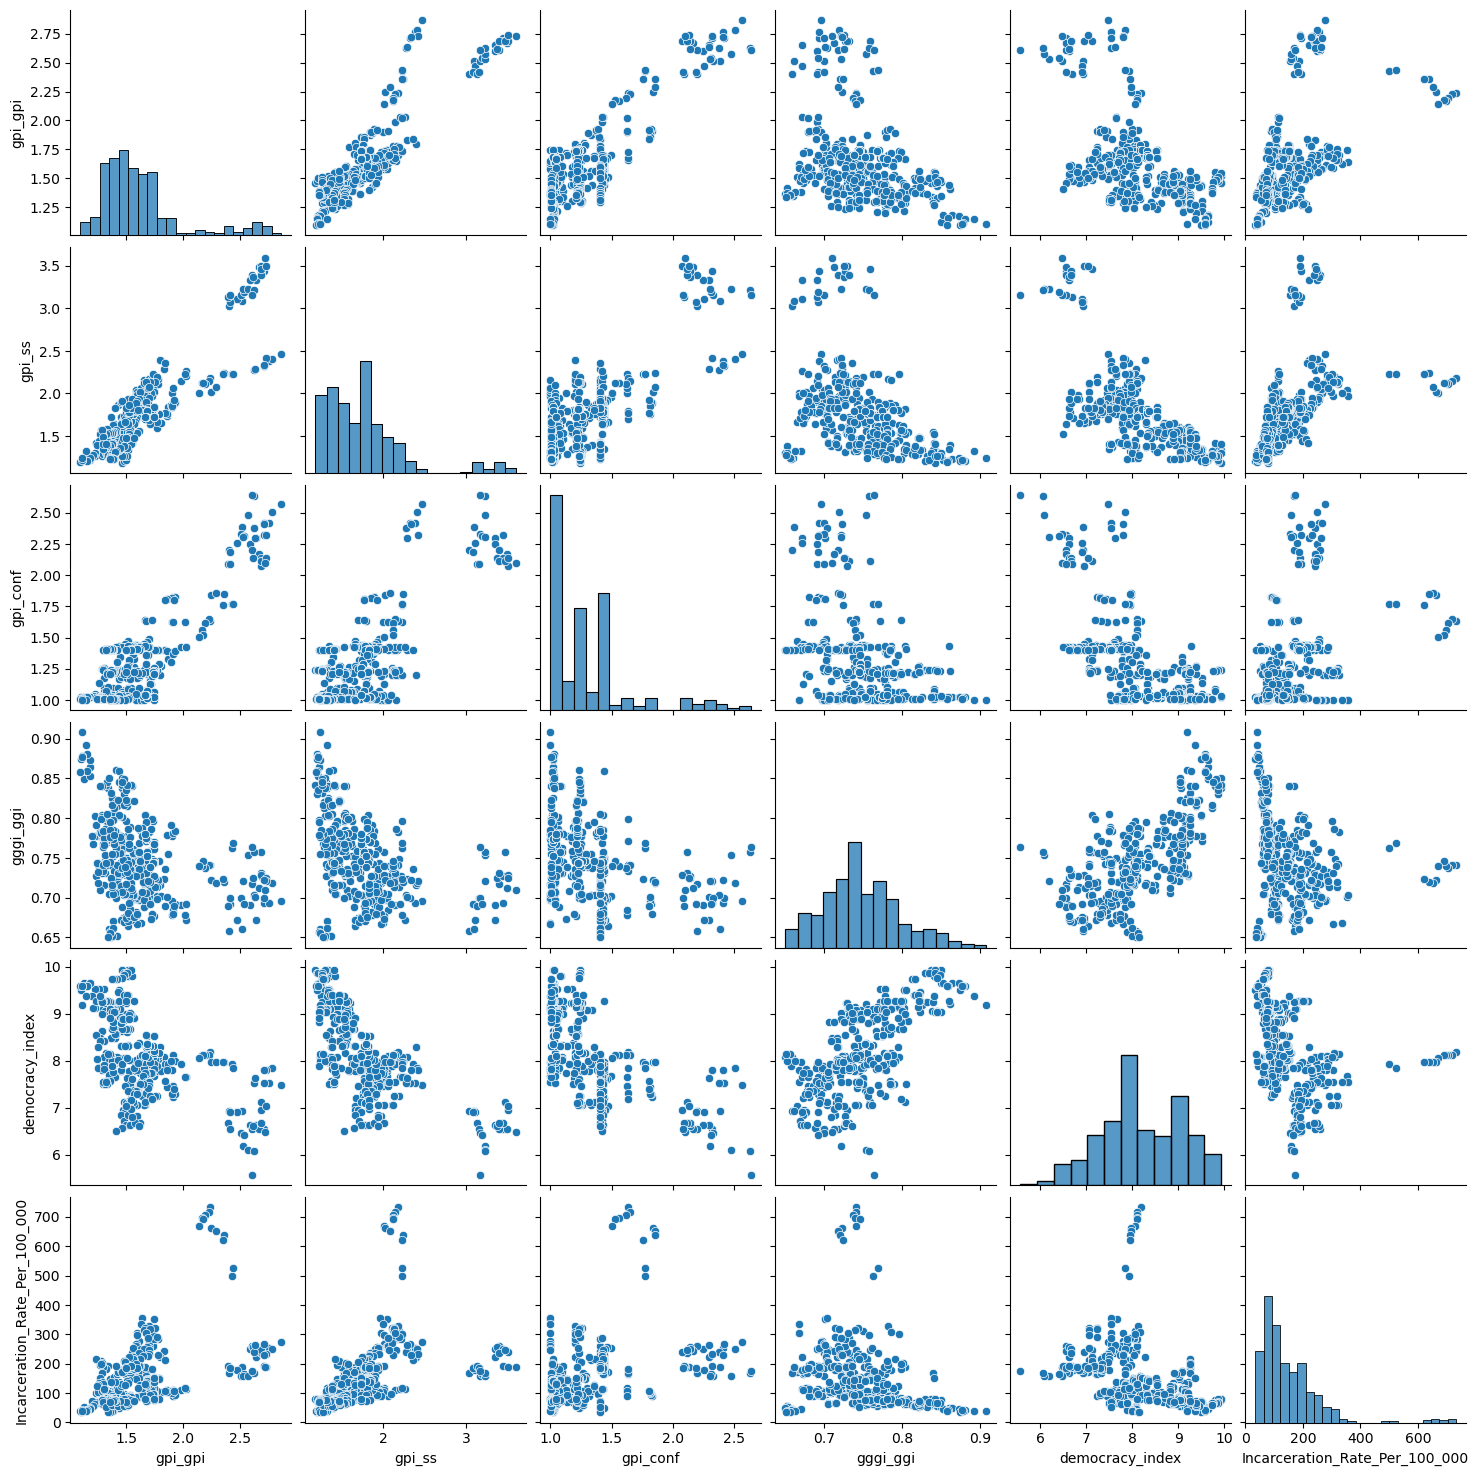

In [99]:
sns.pairplot(pairplot_3_inidicators)

## Modeling Democracy Index using all the variables collected

### Creating dummy variables of the two known categorical columns plus Country column

In [102]:
modeling_data = pd.get_dummies(modeling_data, columns=['gd_ptsa', 'nelda_vcdbe', 'Country'])

In [103]:
# Instantiating variables, model and preprocessing steps
sc=StandardScaler()
imputer = KNNImputer()
rfr = RandomForestRegressor(random_state=1011)
X = modeling_data.drop(columns='democracy_index') 
y = modeling_data['democracy_index']

### Train/Test Split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1011)

### Standard Sacaling data for KNN Imputer

In [105]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Using KNN Imputer to fill in missing values

In [106]:
X_train = imputer.fit_transform(X_train) 
X_test = imputer.transform(X_test)

### Training the model

In [107]:
model_1 = rfr.fit(X_train, y_train)

In [108]:
model_1.score(X_train, y_train), model_1.score(X_test, y_test), 

(0.9945364955737956, 0.9628919769632435)

In [109]:
model_1_best = model_1.base_estimator_
model_1_best.fit(X_train, y_train)
model_1_preds = model_1_best.predict(X_test)

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


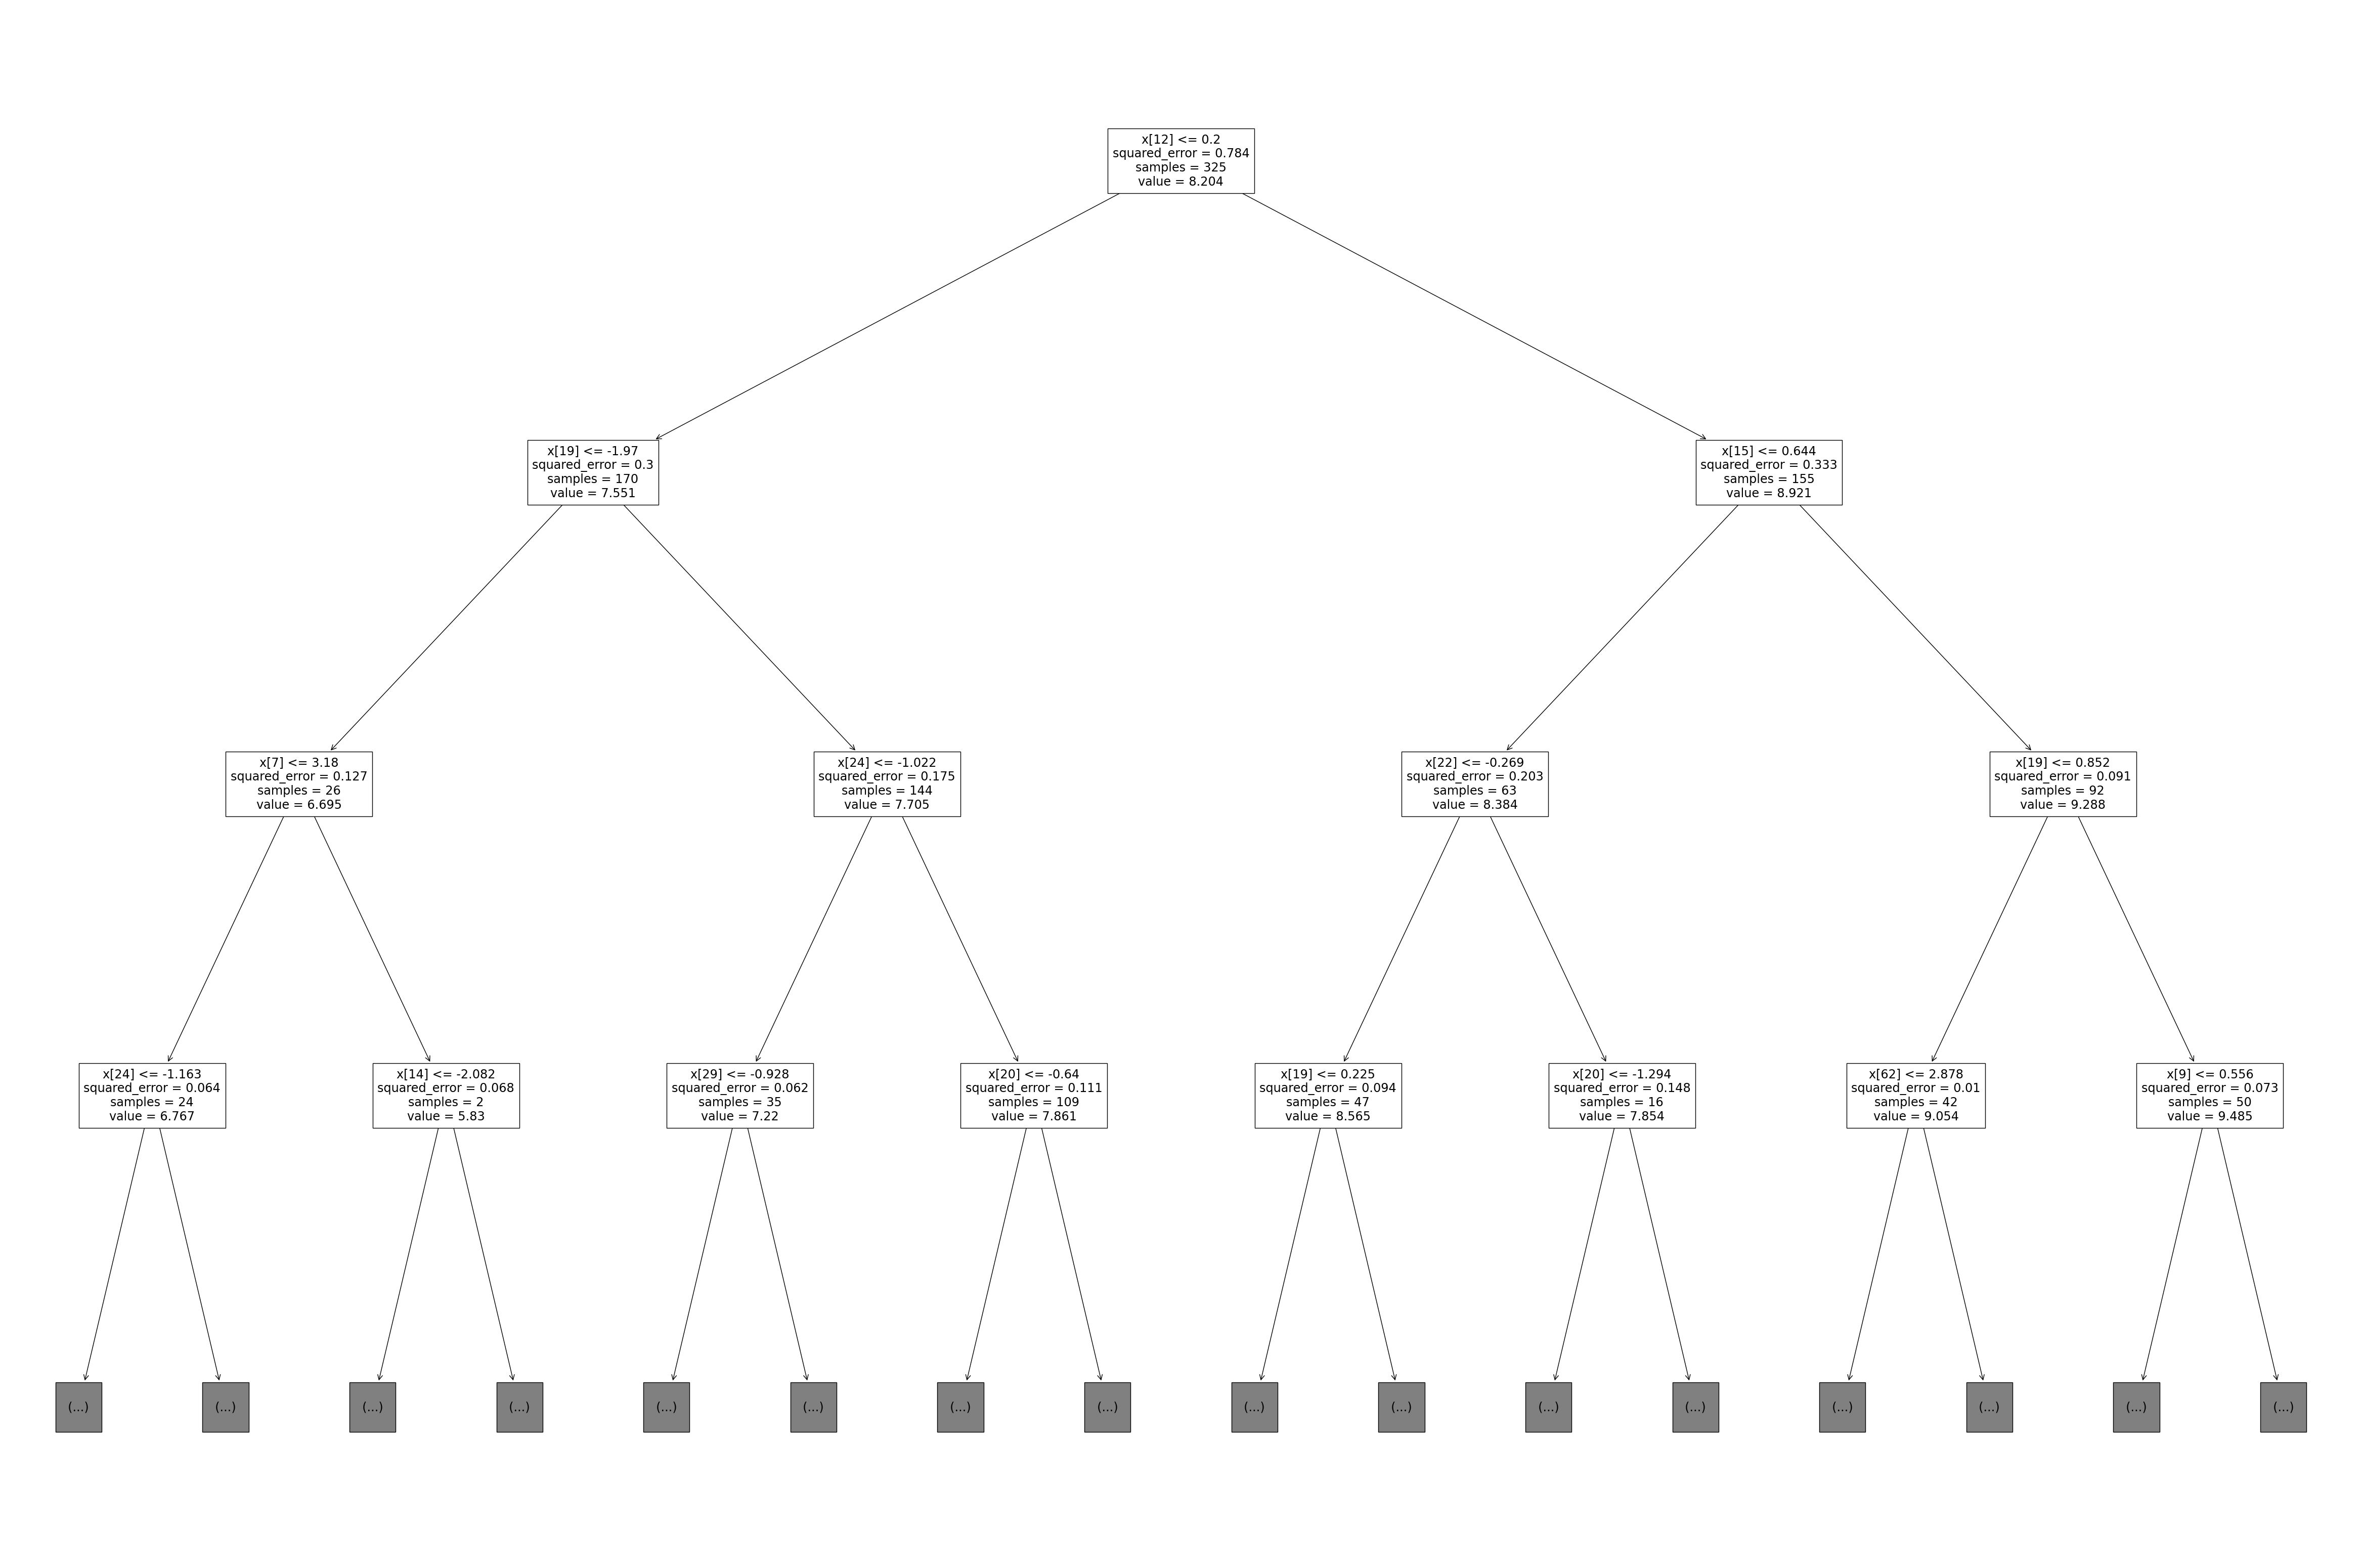

In [110]:
plt.figure(figsize=(60,40))
plot_tree(model_1_best,max_depth=3);

In [111]:
model_1_best_mse = mean_squared_error(y_test, model_1_preds)
model_1_best_mse

0.032824770642201795

## Modeling for Prison Rate using all variables collected

In [112]:
# Instantiating a new X and y; dataset already has dummy variables
X_1 = modeling_data.drop(columns='Incarceration_Rate_Per_100_000')
y_1 = modeling_data['Incarceration_Rate_Per_100_000']

# New train/text split 
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, random_state = 1011)

In [113]:
# Standard Scaling
X_1_train = sc.fit_transform(X_1_train)
X_1_test = sc.transform(X_1_test)

# filling in null values
X_1_train = imputer.fit_transform(X_1_train) 
X_1_test = imputer.transform(X_1_test)

In [114]:
model_2 = rfr.fit(X_train, y_train)
model_2.score(X_1_train, y_1_train), model_1.score(X_1_test, y_1_test)

(-1.7380867953872468, -1.4315365935530782)

In [115]:
model_2_best = model_2.base_estimator_
model_2_best.fit(X_1_train, y_1_train)
model_2_preds = model_2_best.predict(X_1_test)

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


In [116]:
model_2_best_mse = mean_squared_error(y_1_test, model_2_preds)
model_2_best_mse

687.5155161443171

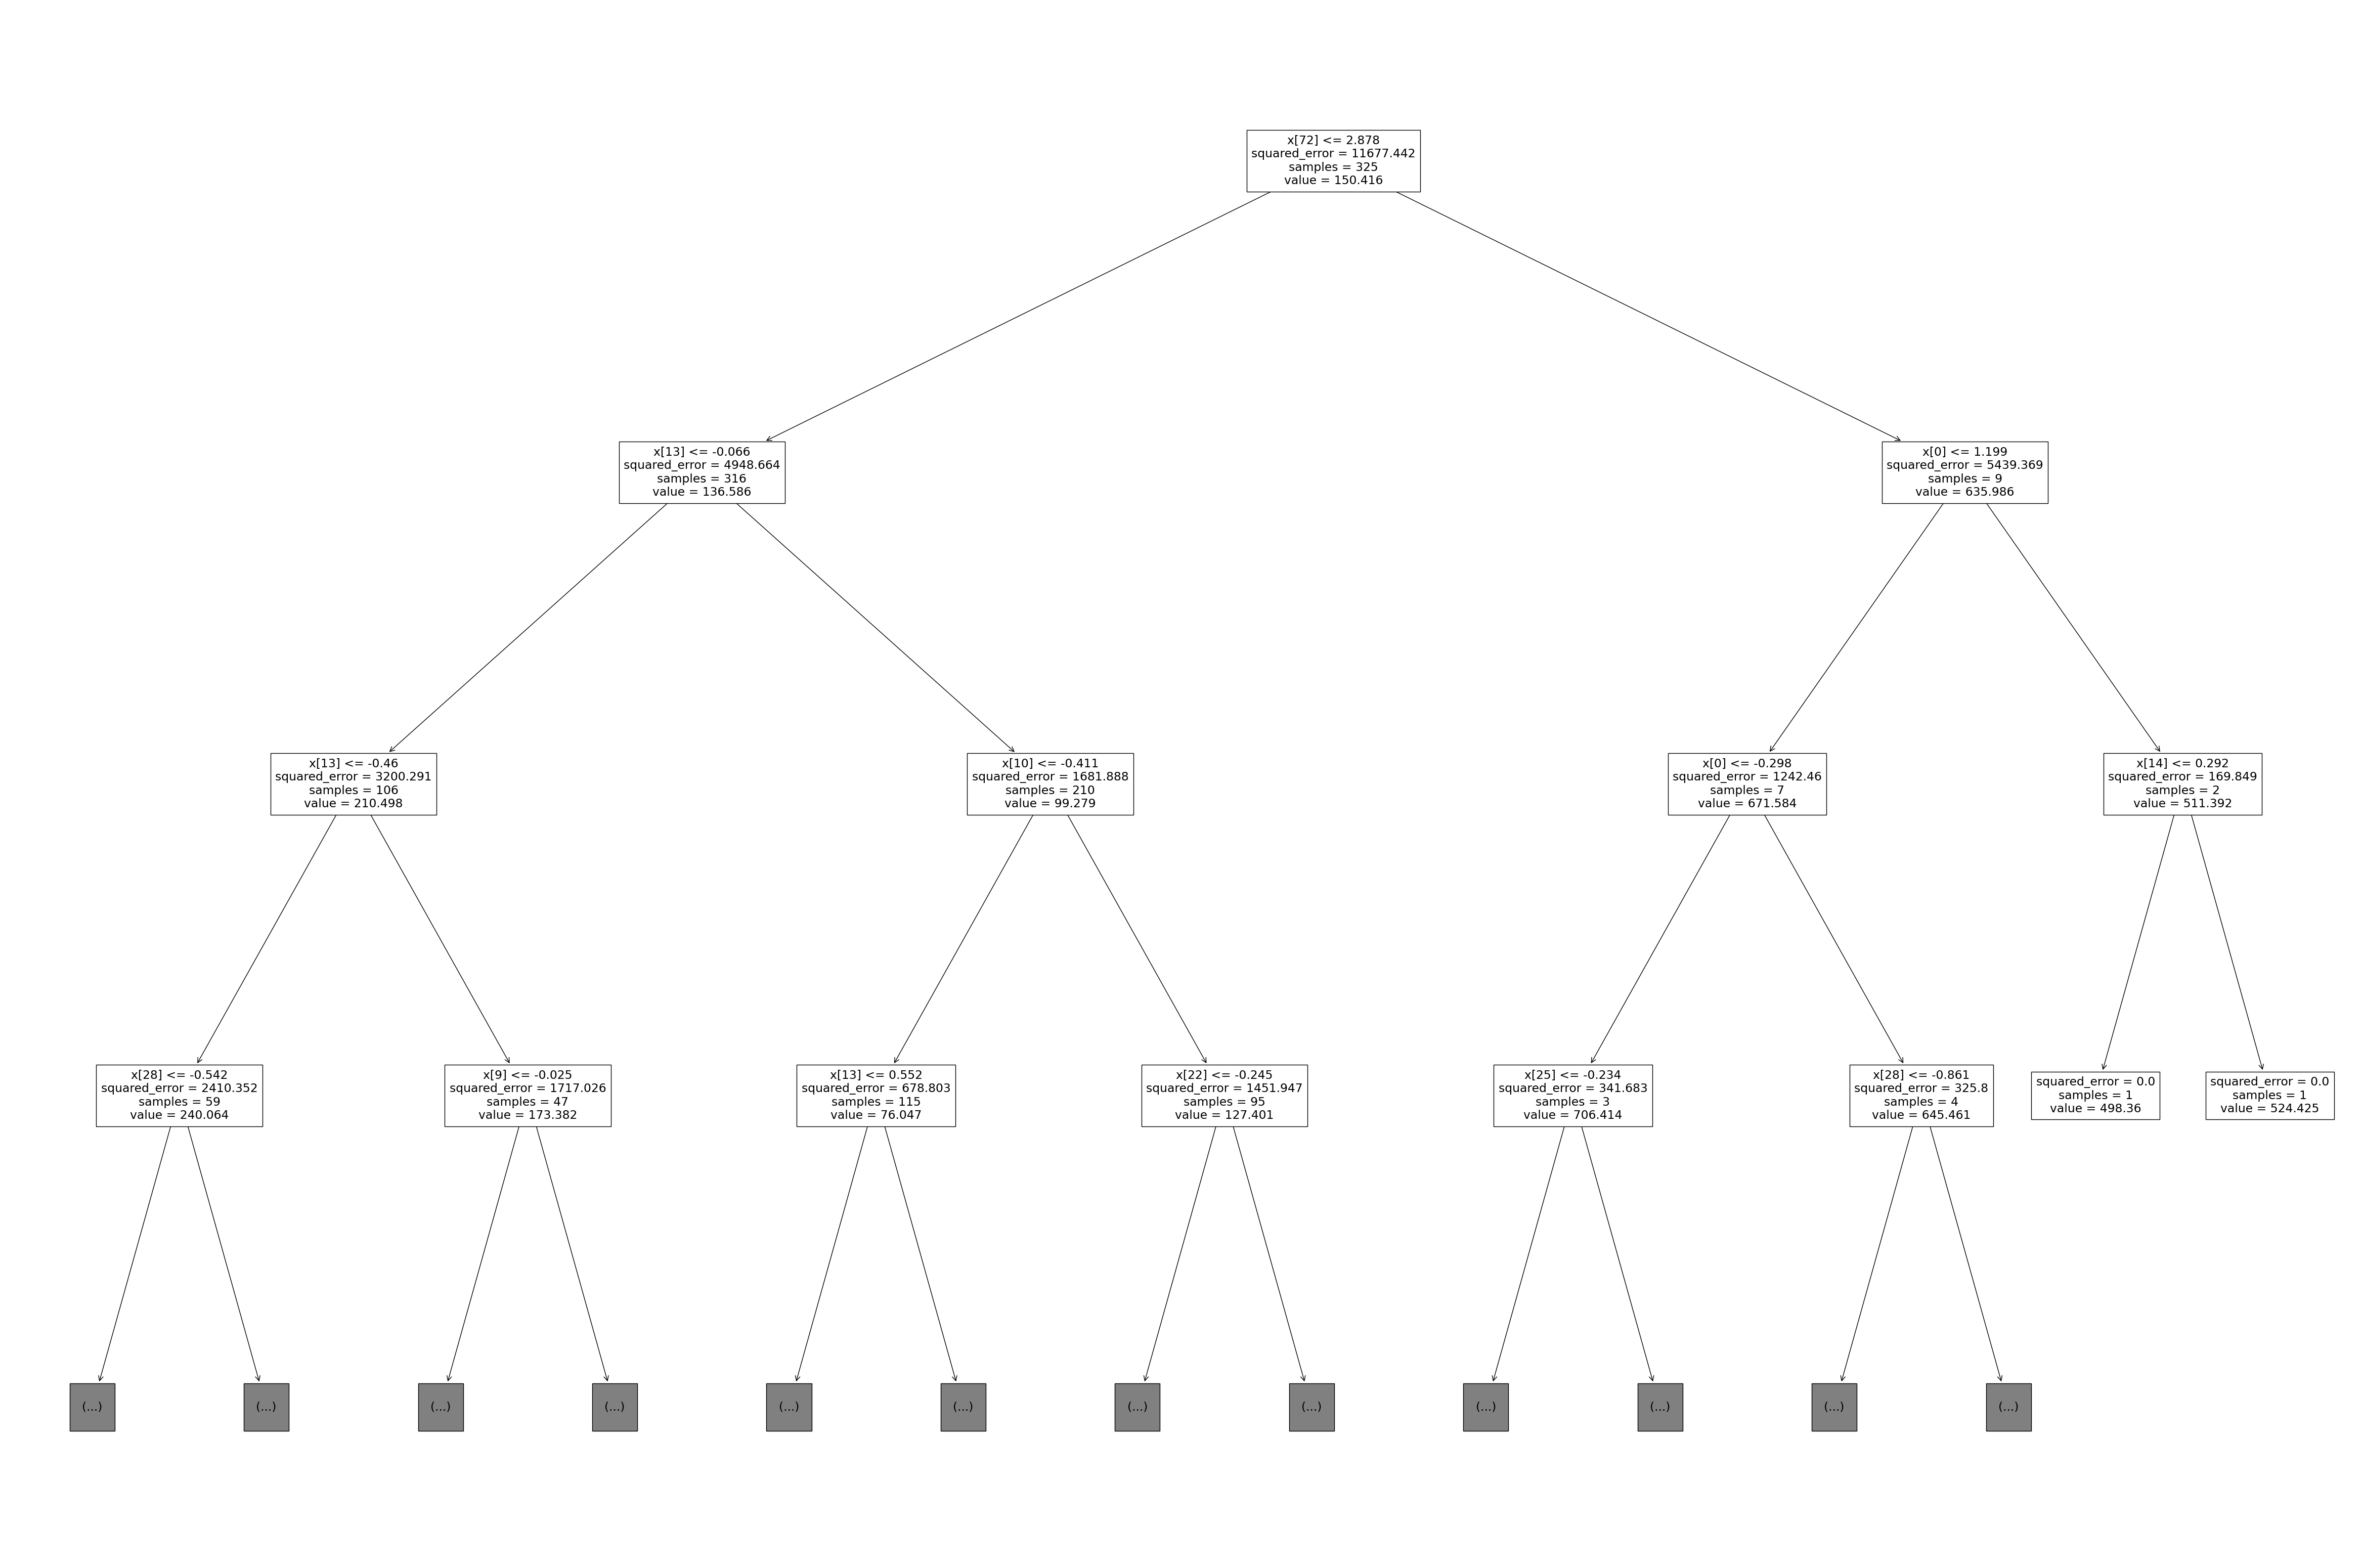

In [117]:
plt.figure(figsize=(60,40))
plot_tree(model_2_best,max_depth=3);

## SUMMARY

#### Modeling of Democracy Index
This model appears to do very well at predicting democracy index including and will be used to compare to the classification regression models trying to predict democracy index using only incarceration rate. 

#### Modeling of Incarceration Rate
Attempting to predict incarceration rate from the other indicators collected does not work at all indicating that in this case economic, and political indicators may not be used to determine incarceration rates of a particular country when that information is missing. 

#### Project Scope

This project scope may be too large and doesn't quite arrive at a conclusion that may effectively summarize the role of incarceration in the spectrum of governance from full democracy to authoritarian regime. This was particularly evident as we presented the different political/economic indicators to the rest of the cohort. 

At this point in time I would not be prepared to publish this project as part of my portfolio, especially because the conclusions drawn with respect to human rights violations and US intervention(thought very well documented in the peer review articles included) can be quite difficult to digest and polarizing. 

I do, however, believe that the phenomenon of mass incarceration and growing trends of authoritarianism are issues of outmost importance that should live in the conscious minds of global citizens. Future steps for me will be to re-evaluate the project taking into account instructor feedback, then I will personally seek the advise of a dear friend who is a Political Science Professor at Metropolitan State University where I graduated from. I believe with his help I can narrow down the scope of the project to be more digestible and could theoretically be of value to journalists, or educators. 

Overall this exercise was still very useful, as a learning experience as it allowed me to experiment with and the imagine that the value that machine learning can bring to political science analysis. 
